In [27]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
import re
# penny
import pennylane as qml
from pennylane.transforms import *
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy
# self-developed
from penny_qiskit_utils_1 import *
from gate_opt_utils_1 import *
from penny_to_graph import Penny_to_Graph


In [5]:
[ds] = qml.data.load("ketgpt")

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72
None


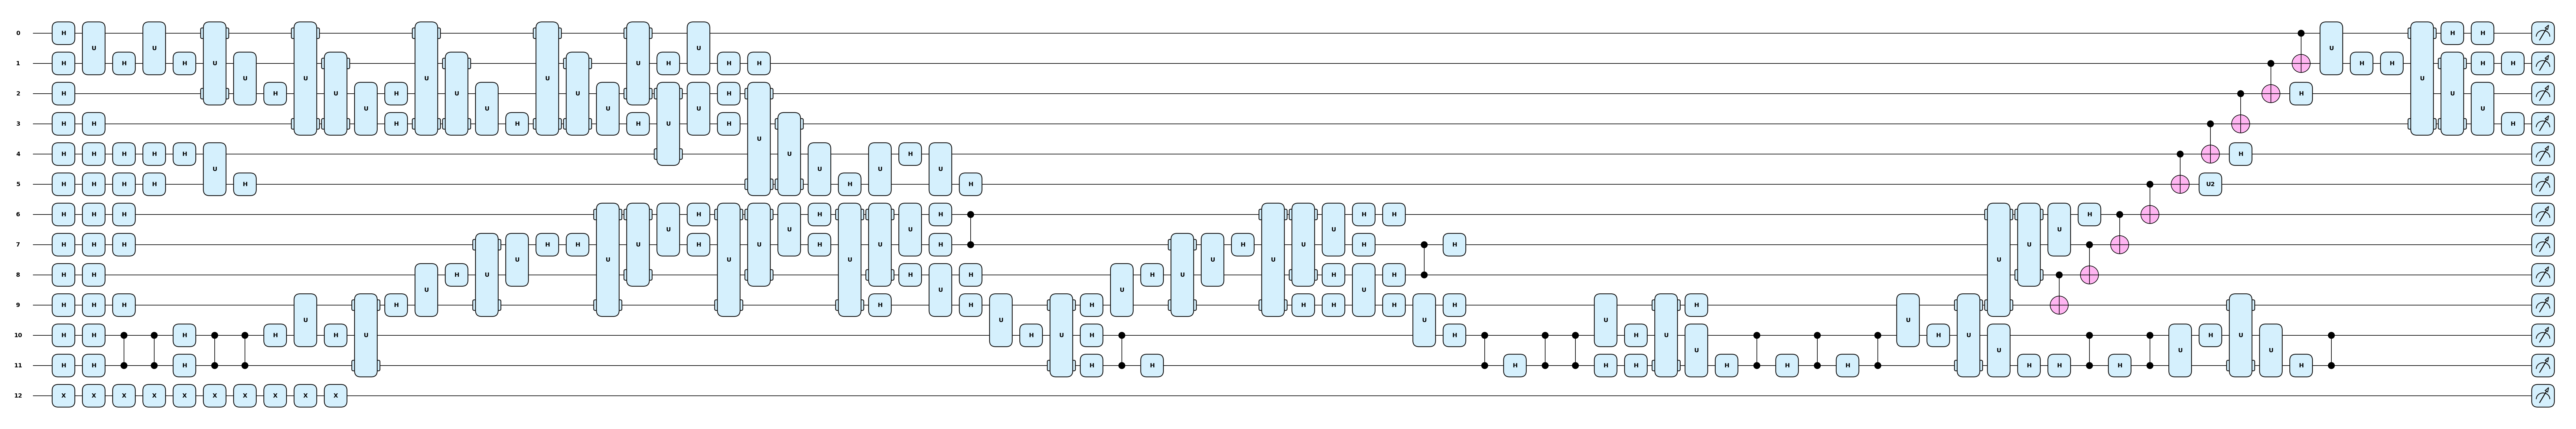

In [37]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

2. Barrier removal

In [41]:
circuit_info = extract_info_from_qnode(circuit)
# circuit_info = remove_barrier(circuit_info)

3. Graph modeling of the quantum circuit
The quantum circuit is graphified to enable topological optimization

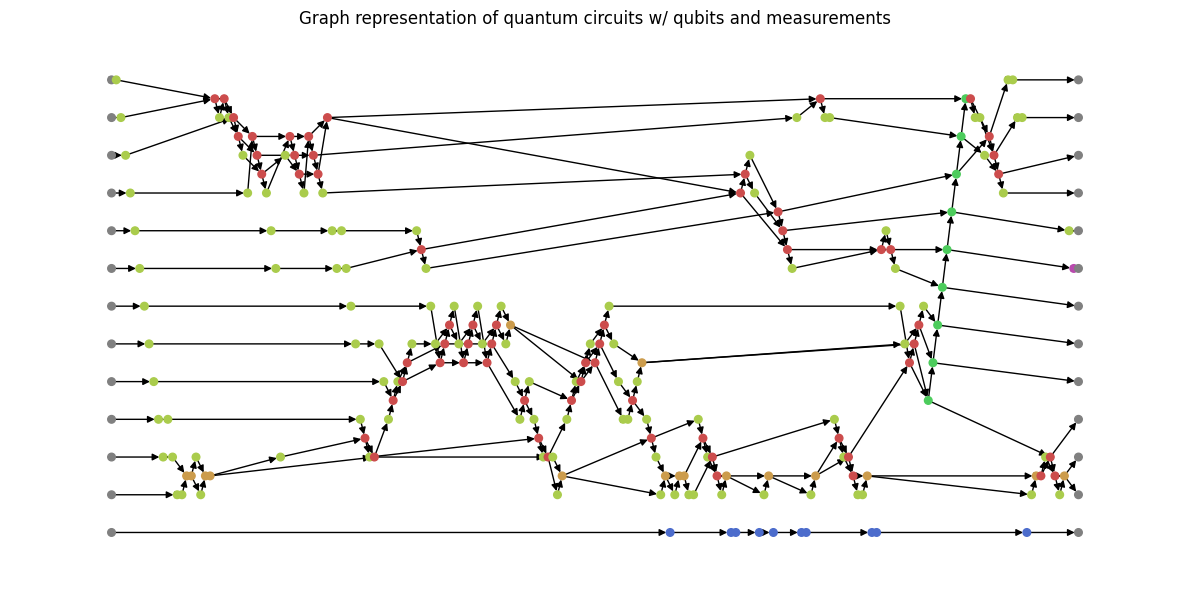

In [42]:
my_pg = Penny_to_Graph(circuit)
G = my_pg.G
my_pg.show_aug_graph()

4. 1q-gate optimization
(barrier setting -> greedy modularity community detection -> gate aggregation)

               0
num_qubit     12
num_gate     153
num_1q_gate   64
num_2q_gate    0
unitary       89
depth         75


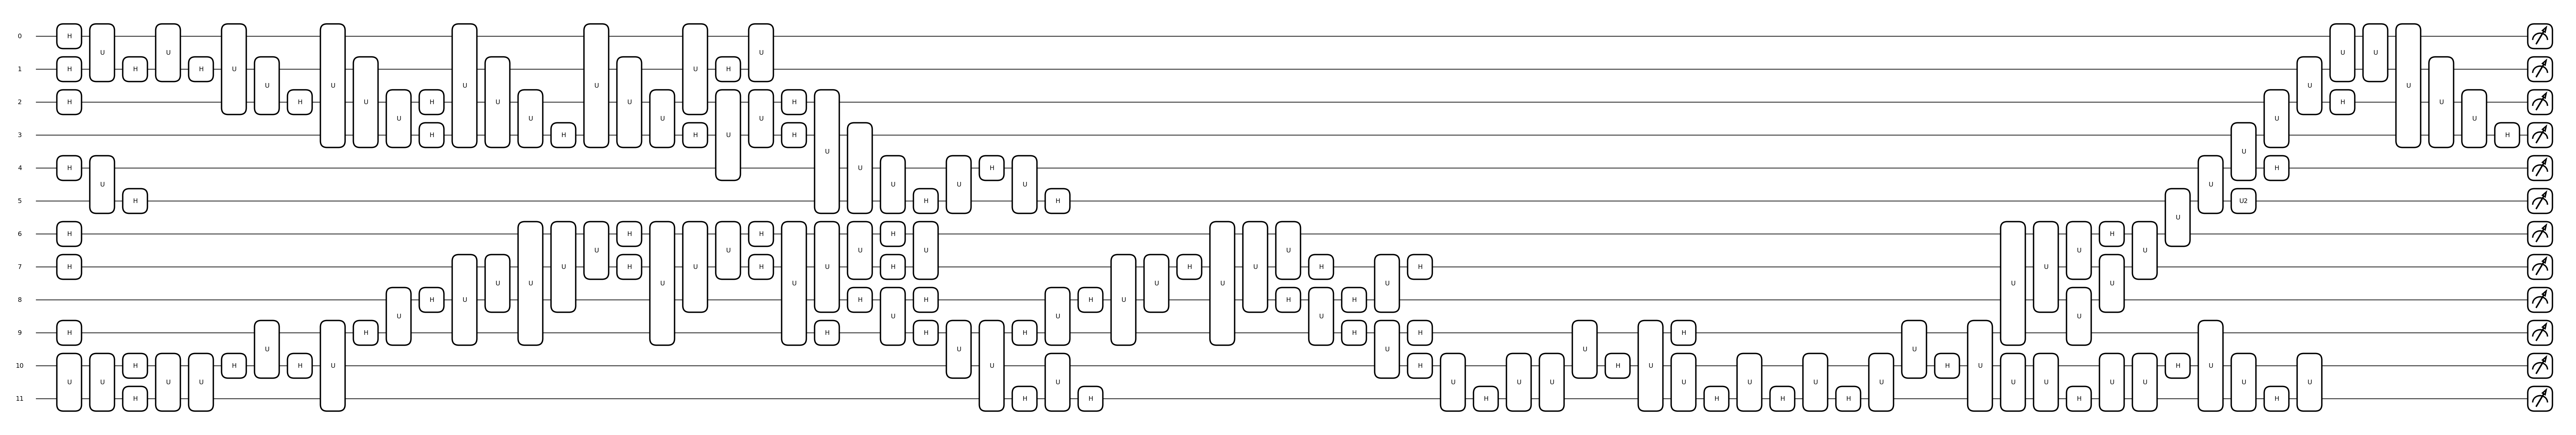

In [ ]:
G, communities = qc_com_detection(G, barriers=['QubitUnitary', 'CNOT', 'CZ'])
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
circuit_lev_1 = level_1_sythesis(effective_u_dic)
summary_penny(circuit_lev_1)
qml.draw_mpl(circuit_lev_1)()
plt.show()

               0
num_qubit     12
num_gate     153
num_1q_gate   64
num_2q_gate   25
unitary       64
depth         75


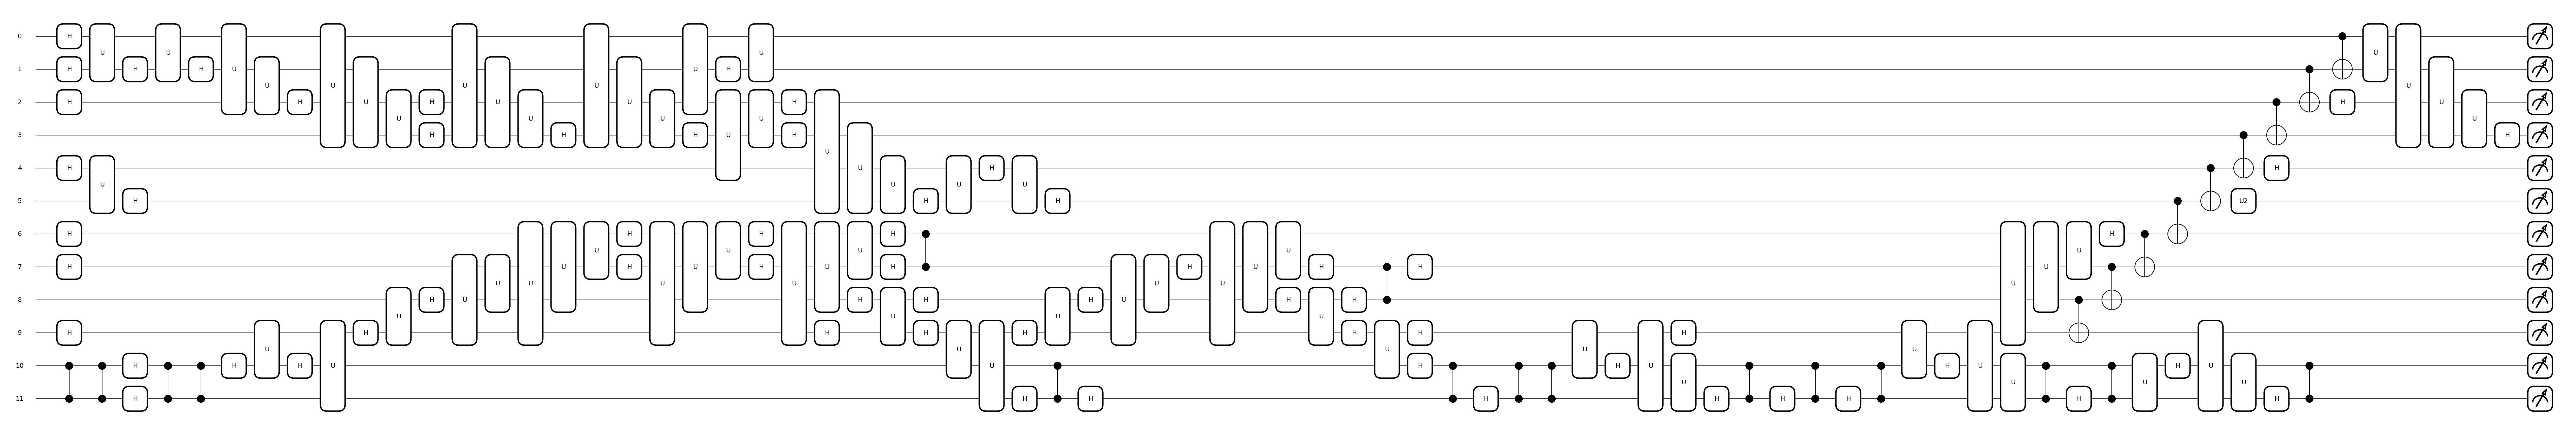

In [44]:
circuit_info = extract_info_from_qnode(circuit_lev_1)
circuit_info = match_2q_gates(circuit_info)
circuit_lev_1 = info_to_qnode(circuit_info)

summary_penny(circuit_lev_1)
qml.draw_mpl(circuit_lev_1)()
plt.show()

4. 2q-gate optimization
(barrier setting -> greedy modularity community detection -> gate aggregation)

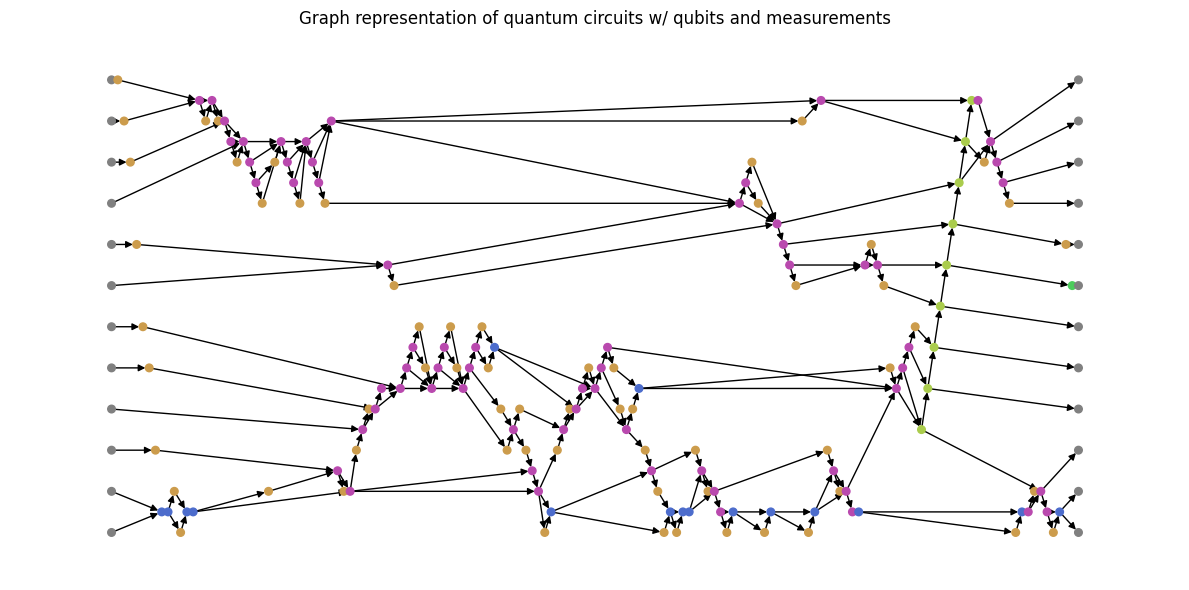

In [49]:
my_pg = Penny_to_Graph(circuit_lev_1)
G = my_pg.G
my_pg.show_aug_graph()

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67


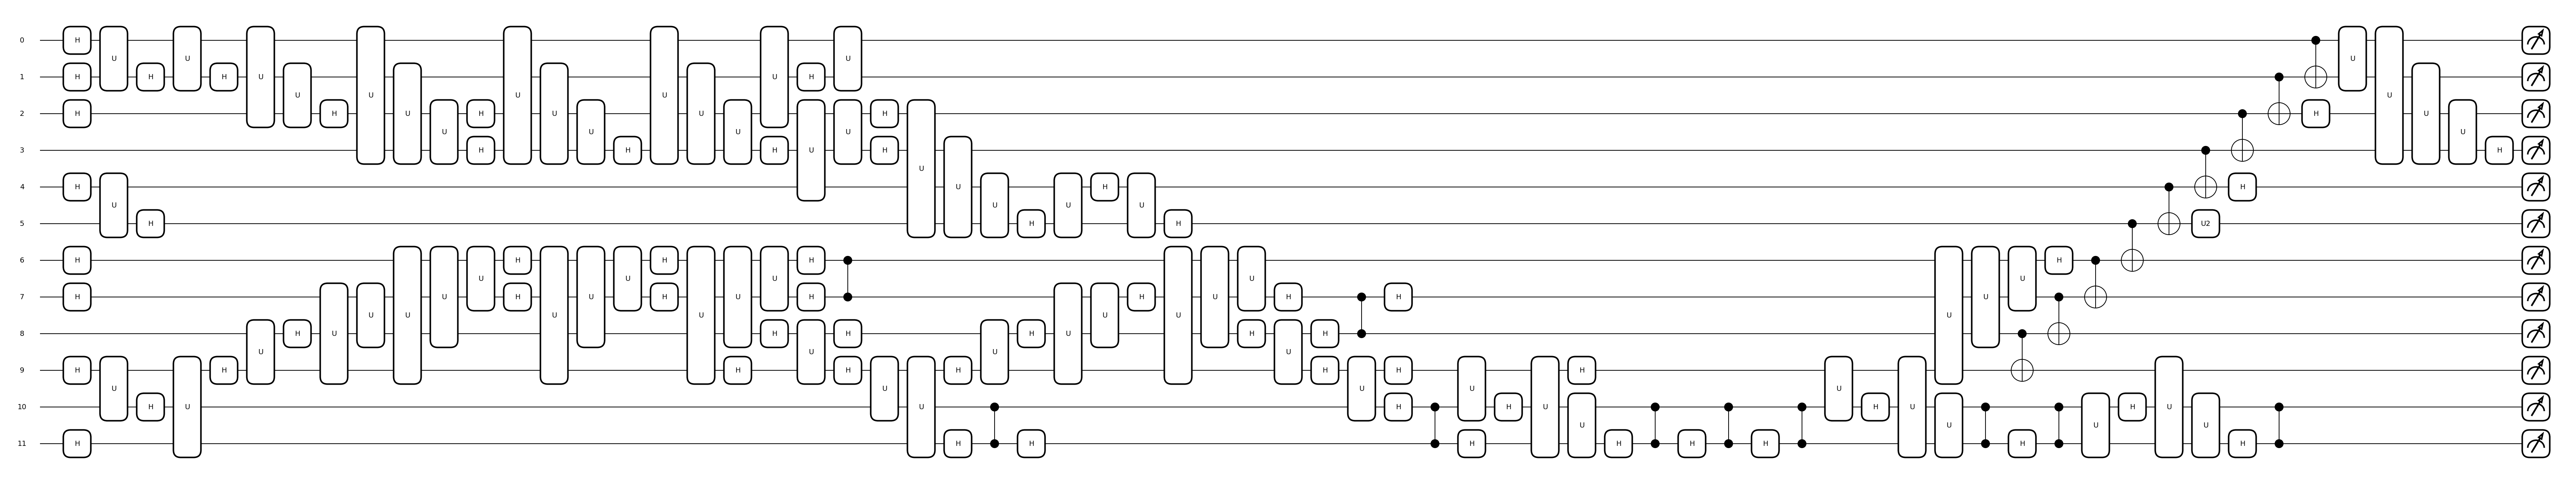

In [55]:
result = cancel_inverses(cancel_inverses(circuit_lev_1))
summary_penny(result)
qml.draw_mpl(result)()
plt.show()

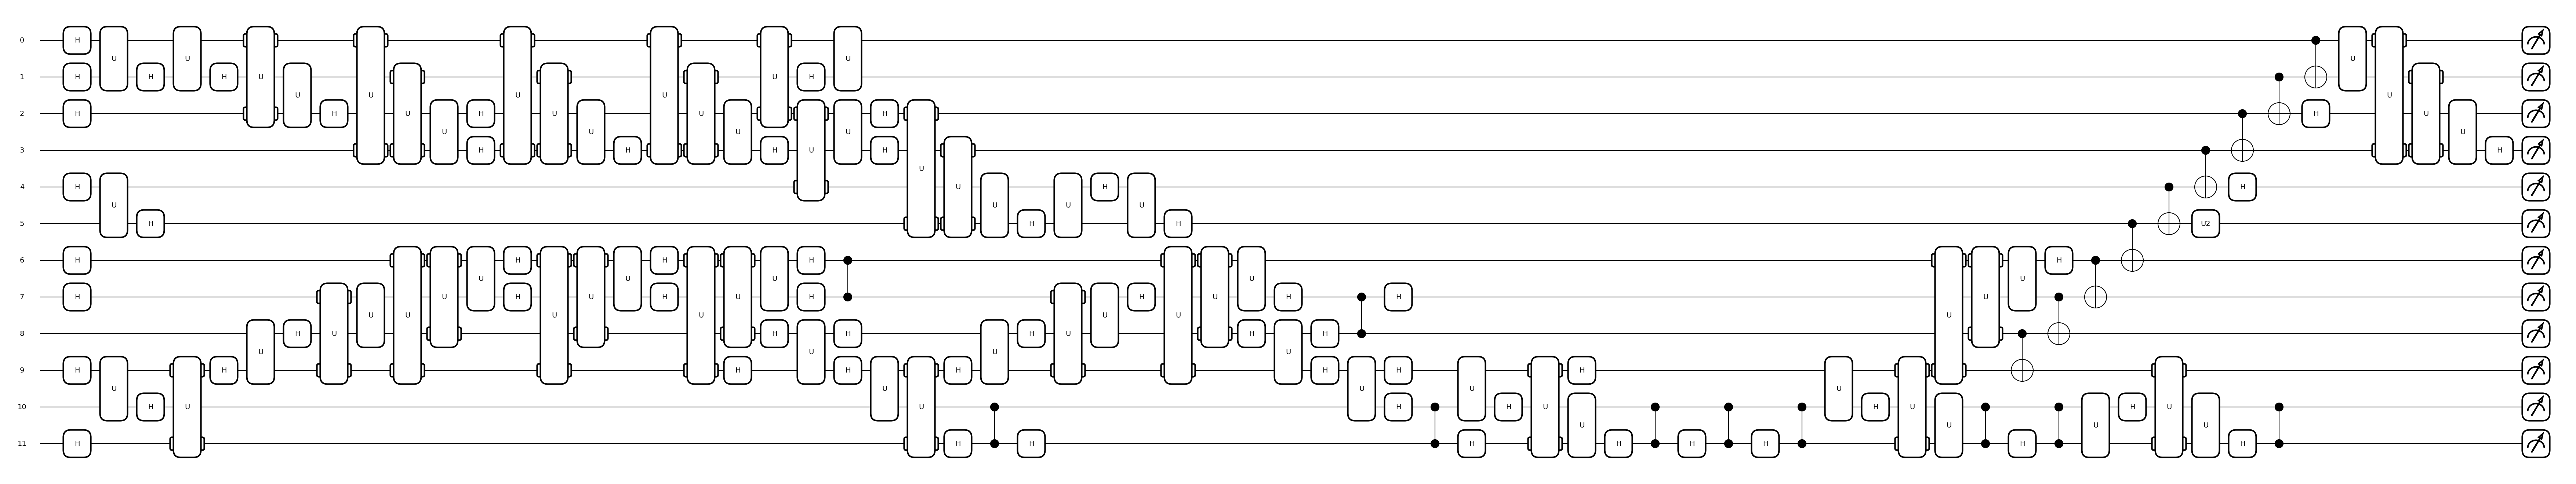

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         59
None


In [56]:
# penny's
@cancel_inverses
@cancel_inverses
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

qml.draw_mpl(circuit)()
plt.show()

print(summary_penny(circuit))